# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

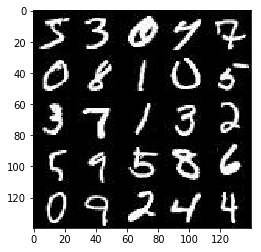

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

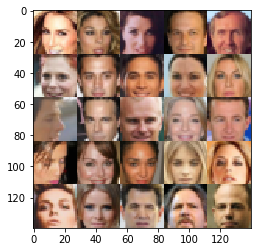

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0


C:\Anaconda3\envs\face_generation\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    #print(z_dim)
    input_images = \
        tf.placeholder\
            (tf.float32, 
             [None,image_width,image_height,image_channels], 
             'input_images')
    z_data = tf.placeholder(tf.float32, [None,z_dim], 'z_data')
    learning_rate = tf.placeholder(tf.float32, [], 'learning_rate')

    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def leaky_RELU(t, alpha=.2):
    return tf.maximum(alpha*t, t)

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #images_shape = images.get_shape().as_list()[1:]
    #print_shape = lambda t: print(t.get_shape().as_list()[1:])
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        #print_shape(images)
        conv1 = \
            tf.layers.conv2d\
                (images, 64, kernel_size=5, strides=2, padding='same',
                 kernel_initializer=\
                     tf.contrib.layers.xavier_initializer_conv2d())
        conv1 = leaky_RELU(conv1)
        #print_shape(conv1)
        # Now 14x14x64
        conv2 = \
            tf.layers.conv2d\
                (conv1, 128, kernel_size=5, strides=2, padding='same',
                 kernel_initializer=\
                     tf.contrib.layers.xavier_initializer_conv2d(),
                 use_bias=False)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = leaky_RELU(conv2)
        #print_shape(conv2)
        # Now 7x7x128
        conv3 = \
            tf.layers.conv2d\
                (conv2, 256, kernel_size=5, strides=2, padding='same',
                 kernel_initializer=\
                     tf.contrib.layers.xavier_initializer_conv2d(),
                 use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = leaky_RELU(conv3)
        #print_shape(conv3)
        # Now 4x4x256
        flatten = tf.contrib.layers.flatten(conv3)
        logits = \
            tf.layers.dense\
                (flatten, 1,
                 kernel_initializer=\
                     tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        fc = \
            tf.layers.dense\
                (inputs=z, units=4*4*512,
                 kernel_initializer=\
                     tf.contrib.layers.xavier_initializer(),
                 use_bias=False)
        fc = tf.reshape(fc, [-1,4,4,512])
        fc = tf.layers.batch_normalization(fc, training=is_train)
        #fc = leaky_RELU(fc)
        fc = tf.nn.relu(fc)
        # Now 4x4x512
        conv1 = tf.image.resize_nearest_neighbor(fc, (8,8))
        conv1 = \
            tf.layers.conv2d\
                (conv1, 256, kernel_size=3, padding='same',
                 kernel_initializer=\
                     tf.contrib.layers.xavier_initializer_conv2d(),
                 use_bias=False)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        #conv1 = leaky_RELU(conv1)
        conv1 = tf.nn.relu(conv1)
        # Now 8x8x256
        conv2 = tf.image.resize_nearest_neighbor(conv1, (16,16))
        conv2 = \
            tf.layers.conv2d\
                (conv2, 128, kernel_size=3, padding='same',
                 kernel_initializer=\
                     tf.contrib.layers.xavier_initializer_conv2d(),
                 use_bias=False)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        #conv2 = leaky_RELU(conv2)
        conv2 = tf.nn.relu(conv2)
        # Now 16x16x128
        conv3 = tf.image.resize_nearest_neighbor(conv2, (28,28))
        conv3 = \
            tf.layers.conv2d\
                (conv3, out_channel_dim, kernel_size=3, padding='same',
                 kernel_initializer=\
                     tf.contrib.layers.xavier_initializer_conv2d())
        out = tf.tanh(conv3)
        #Now 28x28xout_channel_dim
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_out = generator(input_z, out_channel_dim)
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True)
    
    g_loss = \
        tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits\
            (logits=d_fake_logits, labels=tf.ones_like(d_fake_out)))
    d_real_loss = \
        tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits\
            (logits=d_real_logits, 
             labels=tf.ones_like(d_real_out) * (1 - smooth)))
    d_fake_loss = \
        tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits\
            (logits=d_fake_logits, labels=tf.zeros_like(d_fake_out)))
    d_loss = d_real_loss + d_fake_loss 
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    trainable_vars_in_scope = lambda scope_name: \
        [var for var in t_vars if var.name.startswith(scope_name)]
    d_vars = trainable_vars_in_scope('discriminator')
    g_vars = trainable_vars_in_scope('generator')
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer = lambda loss, var_list: \
            tf.train.AdamOptimizer\
                (learning_rate, beta1=beta1).minimize(loss=loss, 
                                                      var_list=var_list)
        d_optimizer = optimizer(d_loss, d_vars)
        g_optimizer = optimizer(g_loss, g_vars)
            
    
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()   
    #image_channels = 3 if data_image_mode == "RGB" else 1
    image_width, image_height, image_channels = data_shape[1:]
    #print(image_width, image_height, image_channels)
    input_images, z_data, rate = \
        model_inputs\
            (image_width=image_width, 
             image_height=image_height, 
             image_channels=image_channels, 
             z_dim=z_dim)
    
    d_loss, g_loss = \
        model_loss(input_images, z_data, image_channels)
    d_optimizer, g_optimizer = \
        model_opt(d_loss, g_loss, rate, beta1)
        
    #sample_z = np.random.uniform(-0.5, 0.5, size=(72, z_dim))
    #samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 40
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = \
                    np.random.uniform(-1, 1, size=[batch_size, z_dim])
                # Run optimizers
                _ = sess.run(d_optimizer, 
                             feed_dict={input_images: batch_images, 
                                        z_data: batch_z,
                                        rate: learning_rate})
                for __ in range(4):
                    _ = sess.run(g_optimizer, 
                                 feed_dict={input_images: batch_images, 
                                            z_data: batch_z,
                                            rate: learning_rate})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = \
                        d_loss.eval({input_images: batch_images, 
                                     z_data: batch_z})
                    train_loss_g = \
                        g_loss.eval({z_data: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output\
                        (sess, 
                         n_images=15, 
                         input_z=z_data, 
                         out_channel_dim=image_channels, 
                         image_mode=data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.1505... Generator Loss: 0.0290
Epoch 1/2... Discriminator Loss: 3.5683... Generator Loss: 0.0455
Epoch 1/2... Discriminator Loss: 2.2037... Generator Loss: 0.3069
Epoch 1/2... Discriminator Loss: 2.1451... Generator Loss: 0.2808


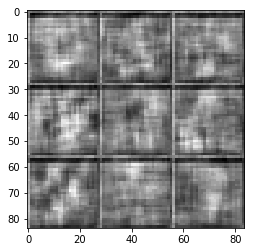

Epoch 1/2... Discriminator Loss: 1.6897... Generator Loss: 1.4169
Epoch 1/2... Discriminator Loss: 2.4246... Generator Loss: 0.1476
Epoch 1/2... Discriminator Loss: 3.1679... Generator Loss: 0.0748
Epoch 1/2... Discriminator Loss: 1.7623... Generator Loss: 0.3410


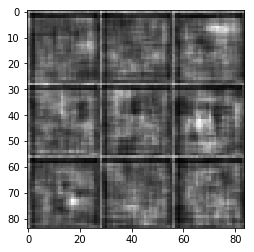

Epoch 1/2... Discriminator Loss: 1.6932... Generator Loss: 0.3615
Epoch 1/2... Discriminator Loss: 1.7381... Generator Loss: 0.3223
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 1.2824
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.1157


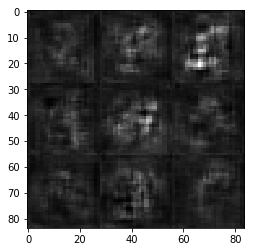

Epoch 1/2... Discriminator Loss: 2.0903... Generator Loss: 0.2195
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 1.8784
Epoch 1/2... Discriminator Loss: 2.3062... Generator Loss: 0.3770
Epoch 1/2... Discriminator Loss: 2.5482... Generator Loss: 0.1243


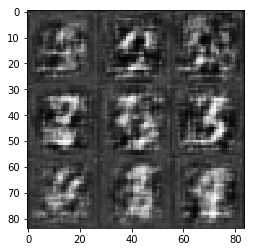

Epoch 1/2... Discriminator Loss: 3.8171... Generator Loss: 0.0377
Epoch 1/2... Discriminator Loss: 2.0434... Generator Loss: 0.2430
Epoch 1/2... Discriminator Loss: 2.0261... Generator Loss: 0.2683
Epoch 1/2... Discriminator Loss: 2.0850... Generator Loss: 0.2153


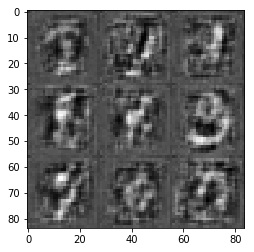

Epoch 1/2... Discriminator Loss: 2.3922... Generator Loss: 0.1473
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 0.6196
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.8840
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.5726


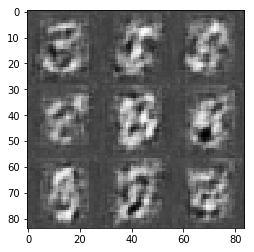

Epoch 1/2... Discriminator Loss: 1.4529... Generator Loss: 0.5058
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 0.8494
Epoch 1/2... Discriminator Loss: 1.7496... Generator Loss: 0.3190


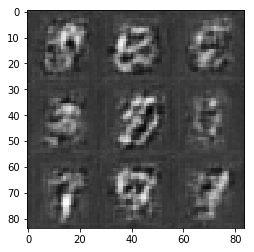

Epoch 1/2... Discriminator Loss: 2.0186... Generator Loss: 0.2451
Epoch 1/2... Discriminator Loss: 1.6366... Generator Loss: 0.3923
Epoch 1/2... Discriminator Loss: 1.2379... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.8147


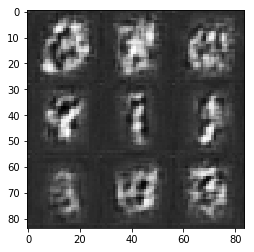

Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 0.5436
Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 0.7615
Epoch 1/2... Discriminator Loss: 1.5989... Generator Loss: 0.3705


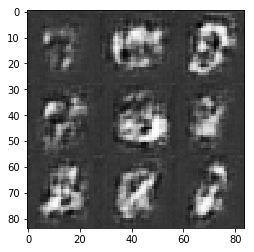

Epoch 1/2... Discriminator Loss: 1.2151... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 1.5709... Generator Loss: 0.3909
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 1.0310
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.4717


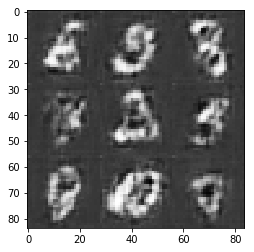

Epoch 1/2... Discriminator Loss: 1.5891... Generator Loss: 0.4020
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 0.6679
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.5572
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 0.9670


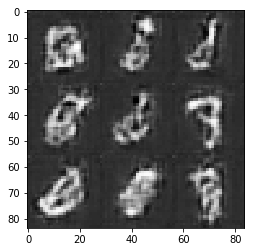

Epoch 1/2... Discriminator Loss: 1.8825... Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 1.1233... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 0.4921... Generator Loss: 2.1665
Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 0.6088


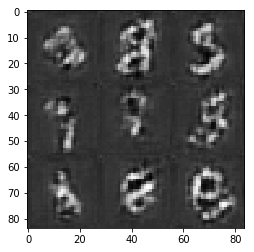

Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 0.9247
Epoch 1/2... Discriminator Loss: 0.5773... Generator Loss: 1.7570
Epoch 1/2... Discriminator Loss: 0.5090... Generator Loss: 2.1442
Epoch 1/2... Discriminator Loss: 0.7750... Generator Loss: 1.2780


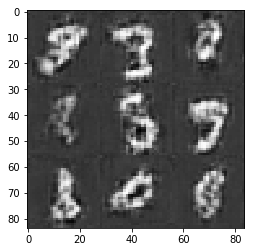

Epoch 1/2... Discriminator Loss: 0.4897... Generator Loss: 2.2269
Epoch 1/2... Discriminator Loss: 0.4082... Generator Loss: 3.0553
Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 1.6071
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.0176


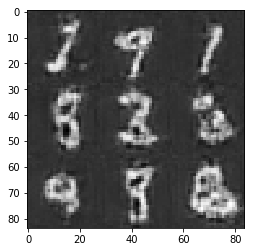

Epoch 1/2... Discriminator Loss: 0.5851... Generator Loss: 1.8883
Epoch 1/2... Discriminator Loss: 1.1402... Generator Loss: 0.7335
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 1.8968
Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 0.4841


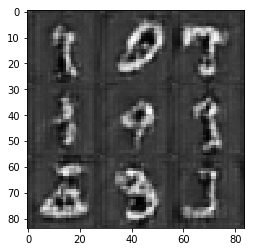

Epoch 1/2... Discriminator Loss: 1.3744... Generator Loss: 0.4691
Epoch 1/2... Discriminator Loss: 0.8577... Generator Loss: 1.0180
Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 0.8442
Epoch 1/2... Discriminator Loss: 0.8784... Generator Loss: 0.9370


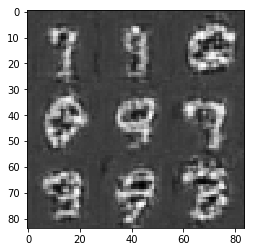

Epoch 1/2... Discriminator Loss: 0.9020... Generator Loss: 0.9177
Epoch 1/2... Discriminator Loss: 0.4387... Generator Loss: 2.6918
Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 0.4896... Generator Loss: 2.0688


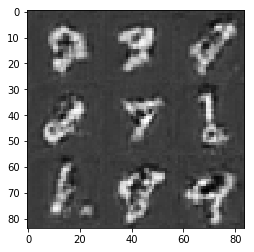

Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 1.0828
Epoch 1/2... Discriminator Loss: 0.4844... Generator Loss: 2.2866
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 1.0365
Epoch 1/2... Discriminator Loss: 0.4689... Generator Loss: 2.3315


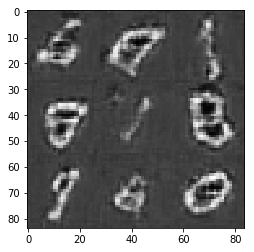

Epoch 1/2... Discriminator Loss: 0.6319... Generator Loss: 1.4951
Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 0.3976... Generator Loss: 4.1257
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 2.6563


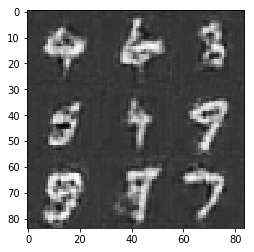

Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.4823
Epoch 1/2... Discriminator Loss: 2.5177... Generator Loss: 1.4279
Epoch 1/2... Discriminator Loss: 1.7444... Generator Loss: 0.3812
Epoch 1/2... Discriminator Loss: 1.6430... Generator Loss: 0.3515


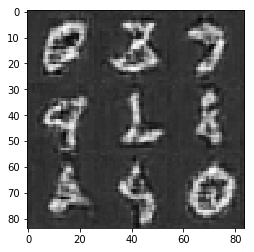

Epoch 1/2... Discriminator Loss: 0.8106... Generator Loss: 1.0656
Epoch 1/2... Discriminator Loss: 0.4543... Generator Loss: 2.3600
Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 0.9400
Epoch 1/2... Discriminator Loss: 0.4694... Generator Loss: 2.2322


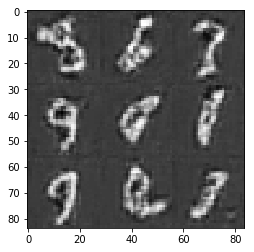

Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 1.5238
Epoch 1/2... Discriminator Loss: 0.5351... Generator Loss: 1.8559
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 0.7295... Generator Loss: 1.3566


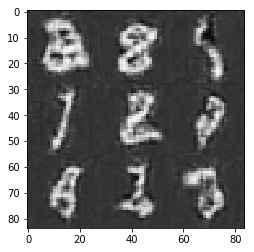

Epoch 1/2... Discriminator Loss: 0.4634... Generator Loss: 2.3596
Epoch 1/2... Discriminator Loss: 0.5848... Generator Loss: 1.6246
Epoch 1/2... Discriminator Loss: 0.5550... Generator Loss: 2.1033
Epoch 1/2... Discriminator Loss: 0.8731... Generator Loss: 1.0538


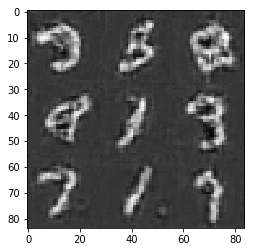

Epoch 1/2... Discriminator Loss: 2.2259... Generator Loss: 0.2922
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 4.2063
Epoch 1/2... Discriminator Loss: 0.5714... Generator Loss: 1.8611
Epoch 1/2... Discriminator Loss: 0.5104... Generator Loss: 2.1350


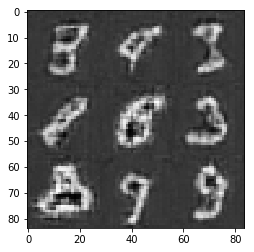

Epoch 1/2... Discriminator Loss: 0.4092... Generator Loss: 3.0023
Epoch 1/2... Discriminator Loss: 0.4308... Generator Loss: 2.5458
Epoch 1/2... Discriminator Loss: 0.4424... Generator Loss: 2.5011
Epoch 1/2... Discriminator Loss: 0.6176... Generator Loss: 1.5620


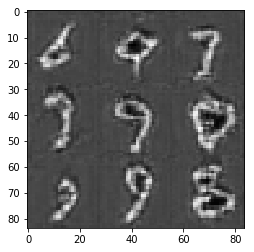

Epoch 1/2... Discriminator Loss: 0.3707... Generator Loss: 3.4815
Epoch 1/2... Discriminator Loss: 0.4422... Generator Loss: 2.5373
Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 3.0345
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 0.7806


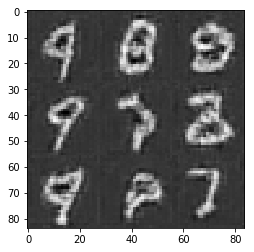

Epoch 1/2... Discriminator Loss: 4.8695... Generator Loss: 6.0797
Epoch 1/2... Discriminator Loss: 0.8412... Generator Loss: 1.4182
Epoch 1/2... Discriminator Loss: 1.3505... Generator Loss: 0.5396
Epoch 1/2... Discriminator Loss: 0.6914... Generator Loss: 1.3516


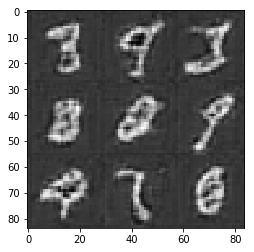

Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 2.7109
Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 2.0254
Epoch 1/2... Discriminator Loss: 2.9580... Generator Loss: 0.1248
Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 0.6219


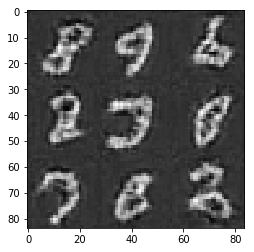

Epoch 1/2... Discriminator Loss: 0.5994... Generator Loss: 1.6144
Epoch 1/2... Discriminator Loss: 1.0631... Generator Loss: 2.4579
Epoch 1/2... Discriminator Loss: 0.5340... Generator Loss: 1.9708
Epoch 1/2... Discriminator Loss: 0.4007... Generator Loss: 4.3783


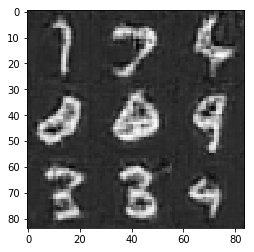

Epoch 1/2... Discriminator Loss: 0.5438... Generator Loss: 1.8224
Epoch 1/2... Discriminator Loss: 0.3532... Generator Loss: 3.9967
Epoch 1/2... Discriminator Loss: 0.4079... Generator Loss: 2.8075
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 2.8396


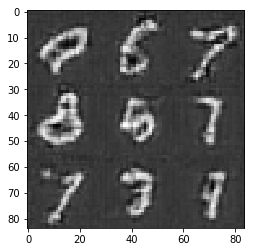

Epoch 1/2... Discriminator Loss: 0.4577... Generator Loss: 2.2551
Epoch 1/2... Discriminator Loss: 0.3488... Generator Loss: 4.5616
Epoch 1/2... Discriminator Loss: 0.4852... Generator Loss: 2.1283
Epoch 1/2... Discriminator Loss: 0.4059... Generator Loss: 2.8497


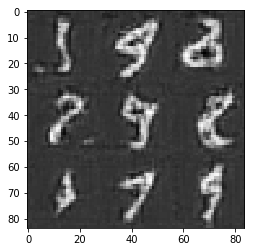

Epoch 1/2... Discriminator Loss: 0.3844... Generator Loss: 3.2505
Epoch 1/2... Discriminator Loss: 0.4697... Generator Loss: 2.1494
Epoch 1/2... Discriminator Loss: 0.3489... Generator Loss: 4.2548
Epoch 1/2... Discriminator Loss: 0.7583... Generator Loss: 2.2911


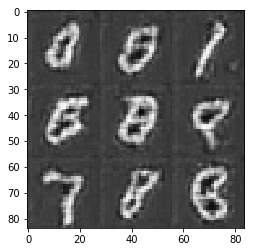

Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 1.0998
Epoch 1/2... Discriminator Loss: 0.4216... Generator Loss: 2.7302
Epoch 1/2... Discriminator Loss: 0.3782... Generator Loss: 3.5036
Epoch 1/2... Discriminator Loss: 0.3947... Generator Loss: 3.4367


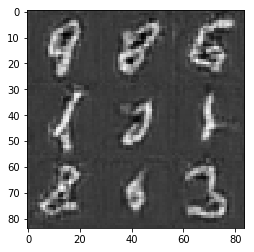

Epoch 1/2... Discriminator Loss: 0.6072... Generator Loss: 1.5414
Epoch 1/2... Discriminator Loss: 0.4107... Generator Loss: 2.8114
Epoch 1/2... Discriminator Loss: 3.5596... Generator Loss: 0.0602
Epoch 1/2... Discriminator Loss: 1.9190... Generator Loss: 0.2890


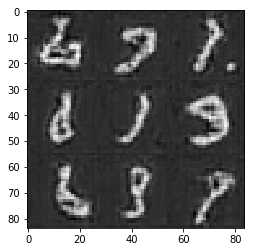

Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 1.7180
Epoch 1/2... Discriminator Loss: 0.4935... Generator Loss: 2.0612
Epoch 1/2... Discriminator Loss: 0.5365... Generator Loss: 2.0513
Epoch 1/2... Discriminator Loss: 0.3379... Generator Loss: 6.4660


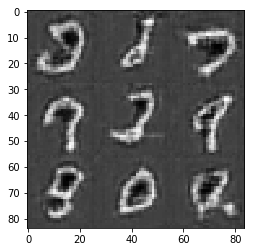

Epoch 1/2... Discriminator Loss: 0.5303... Generator Loss: 2.0085
Epoch 1/2... Discriminator Loss: 0.5760... Generator Loss: 1.5982
Epoch 1/2... Discriminator Loss: 0.9708... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 2.7595


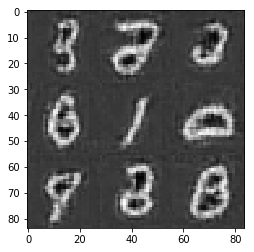

Epoch 1/2... Discriminator Loss: 0.5020... Generator Loss: 2.0571
Epoch 1/2... Discriminator Loss: 2.9153... Generator Loss: 3.7708
Epoch 1/2... Discriminator Loss: 1.4170... Generator Loss: 0.6328
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.5434


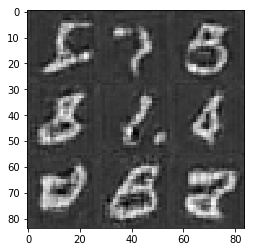

Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.5284
Epoch 1/2... Discriminator Loss: 0.4147... Generator Loss: 4.8850
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 1.7215
Epoch 1/2... Discriminator Loss: 0.4189... Generator Loss: 2.9699


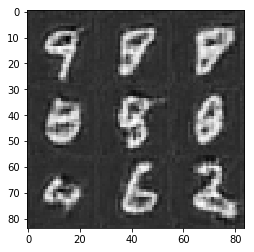

Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.0053
Epoch 1/2... Discriminator Loss: 0.3759... Generator Loss: 3.3018
Epoch 1/2... Discriminator Loss: 0.3464... Generator Loss: 4.5046
Epoch 1/2... Discriminator Loss: 0.4950... Generator Loss: 3.1412


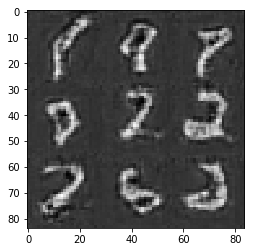

Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.6624
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 1.1733
Epoch 1/2... Discriminator Loss: 0.3685... Generator Loss: 4.1598
Epoch 1/2... Discriminator Loss: 0.6383... Generator Loss: 1.4645


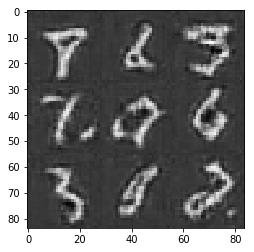

Epoch 1/2... Discriminator Loss: 0.8227... Generator Loss: 1.0226
Epoch 1/2... Discriminator Loss: 0.3821... Generator Loss: 3.3900
Epoch 1/2... Discriminator Loss: 0.4974... Generator Loss: 1.9927
Epoch 1/2... Discriminator Loss: 0.4755... Generator Loss: 2.0829


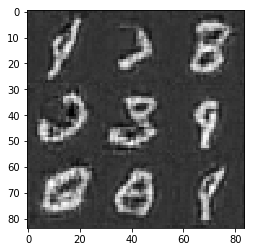

Epoch 1/2... Discriminator Loss: 0.4157... Generator Loss: 3.4107
Epoch 1/2... Discriminator Loss: 0.3732... Generator Loss: 4.1823
Epoch 1/2... Discriminator Loss: 0.3579... Generator Loss: 3.7959
Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 1.5311


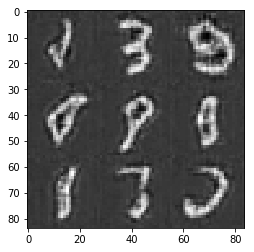

Epoch 1/2... Discriminator Loss: 0.3659... Generator Loss: 3.6271
Epoch 1/2... Discriminator Loss: 0.4635... Generator Loss: 2.2824
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 3.7977
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.7349


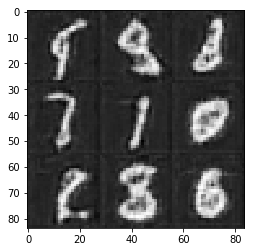

Epoch 1/2... Discriminator Loss: 1.1132... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 0.9322... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.8141


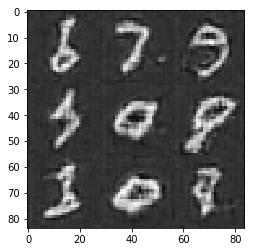

Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 1.0026
Epoch 1/2... Discriminator Loss: 0.4314... Generator Loss: 3.6521
Epoch 1/2... Discriminator Loss: 0.6087... Generator Loss: 1.5254
Epoch 1/2... Discriminator Loss: 0.3543... Generator Loss: 4.2863


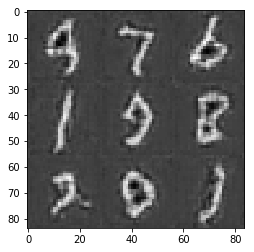

Epoch 1/2... Discriminator Loss: 0.6889... Generator Loss: 1.3587
Epoch 1/2... Discriminator Loss: 0.5410... Generator Loss: 1.7826
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 1.3226... Generator Loss: 0.5528


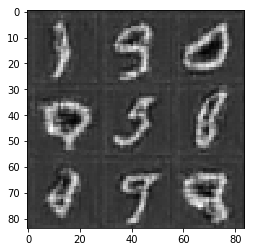

Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 2.0233
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 1.0302
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.1386
Epoch 2/2... Discriminator Loss: 0.6372... Generator Loss: 2.1705


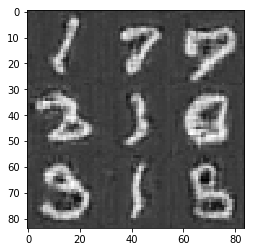

Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 1.7324
Epoch 2/2... Discriminator Loss: 0.4038... Generator Loss: 3.0423
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 0.8166
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 1.1928


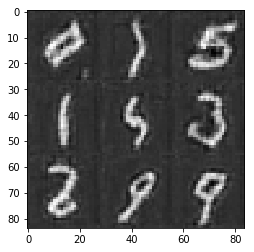

Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 1.6070
Epoch 2/2... Discriminator Loss: 0.5412... Generator Loss: 1.9304
Epoch 2/2... Discriminator Loss: 0.3991... Generator Loss: 4.3820
Epoch 2/2... Discriminator Loss: 0.3886... Generator Loss: 4.3717


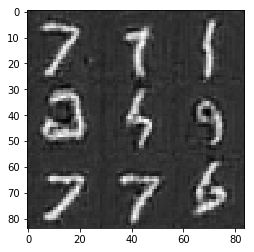

Epoch 2/2... Discriminator Loss: 0.3513... Generator Loss: 4.4127
Epoch 2/2... Discriminator Loss: 0.5070... Generator Loss: 1.9546
Epoch 2/2... Discriminator Loss: 0.3605... Generator Loss: 4.0925
Epoch 2/2... Discriminator Loss: 0.5809... Generator Loss: 1.6239


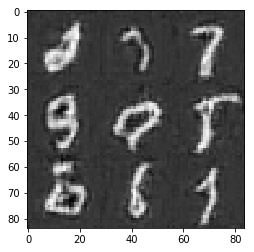

Epoch 2/2... Discriminator Loss: 0.3433... Generator Loss: 4.9922
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 2.1216
Epoch 2/2... Discriminator Loss: 1.5783... Generator Loss: 0.4116
Epoch 2/2... Discriminator Loss: 0.7181... Generator Loss: 1.4536


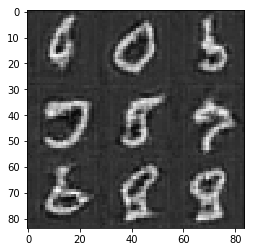

Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 0.7029... Generator Loss: 1.9988
Epoch 2/2... Discriminator Loss: 0.4394... Generator Loss: 2.5626
Epoch 2/2... Discriminator Loss: 1.4089... Generator Loss: 0.4786


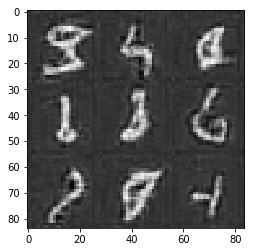

Epoch 2/2... Discriminator Loss: 1.9838... Generator Loss: 5.1414
Epoch 2/2... Discriminator Loss: 0.9853... Generator Loss: 2.0406
Epoch 2/2... Discriminator Loss: 0.7037... Generator Loss: 1.5021
Epoch 2/2... Discriminator Loss: 0.5116... Generator Loss: 2.4745


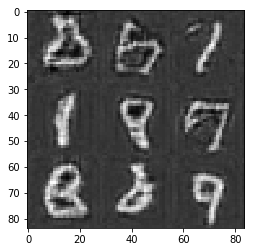

Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 1.1803
Epoch 2/2... Discriminator Loss: 0.4367... Generator Loss: 2.9540
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.0816
Epoch 2/2... Discriminator Loss: 0.3746... Generator Loss: 3.3928


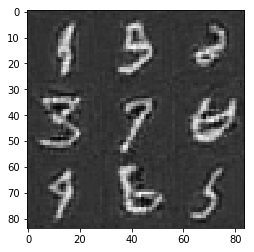

Epoch 2/2... Discriminator Loss: 0.4553... Generator Loss: 2.3938
Epoch 2/2... Discriminator Loss: 1.4723... Generator Loss: 0.4705
Epoch 2/2... Discriminator Loss: 0.9573... Generator Loss: 0.8460
Epoch 2/2... Discriminator Loss: 0.4718... Generator Loss: 2.2538


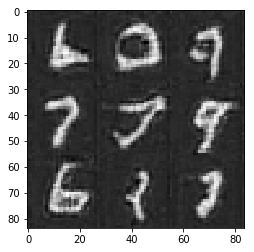

Epoch 2/2... Discriminator Loss: 0.4059... Generator Loss: 2.8585
Epoch 2/2... Discriminator Loss: 0.3509... Generator Loss: 4.3018
Epoch 2/2... Discriminator Loss: 0.4505... Generator Loss: 2.4426
Epoch 2/2... Discriminator Loss: 0.4321... Generator Loss: 2.6640


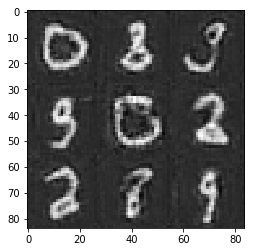

Epoch 2/2... Discriminator Loss: 0.3393... Generator Loss: 5.4027
Epoch 2/2... Discriminator Loss: 0.5947... Generator Loss: 1.8815
Epoch 2/2... Discriminator Loss: 0.8140... Generator Loss: 1.1410
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.0838


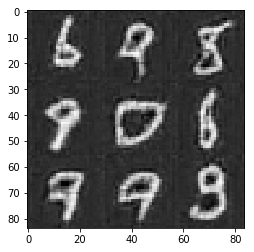

Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 0.9603
Epoch 2/2... Discriminator Loss: 0.7263... Generator Loss: 1.3403
Epoch 2/2... Discriminator Loss: 0.4305... Generator Loss: 2.9423
Epoch 2/2... Discriminator Loss: 0.4415... Generator Loss: 2.5353


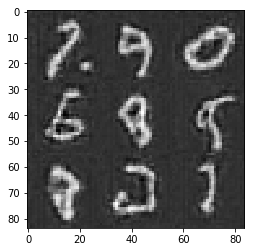

Epoch 2/2... Discriminator Loss: 0.6344... Generator Loss: 1.5669
Epoch 2/2... Discriminator Loss: 1.5430... Generator Loss: 0.4804
Epoch 2/2... Discriminator Loss: 0.3536... Generator Loss: 4.2670
Epoch 2/2... Discriminator Loss: 0.3463... Generator Loss: 5.1906


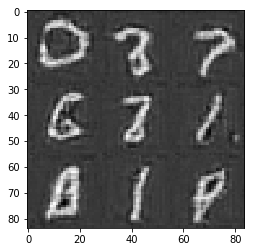

Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 1.4422
Epoch 2/2... Discriminator Loss: 0.6964... Generator Loss: 1.3317
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.4724
Epoch 2/2... Discriminator Loss: 0.5775... Generator Loss: 1.6754


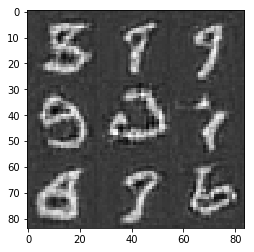

Epoch 2/2... Discriminator Loss: 0.9537... Generator Loss: 0.8941
Epoch 2/2... Discriminator Loss: 0.3849... Generator Loss: 3.3259
Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 0.8640
Epoch 2/2... Discriminator Loss: 0.3753... Generator Loss: 3.6410


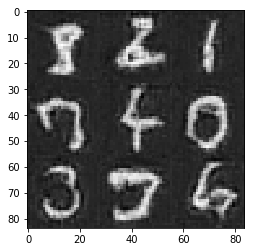

Epoch 2/2... Discriminator Loss: 0.4147... Generator Loss: 3.6136
Epoch 2/2... Discriminator Loss: 0.6544... Generator Loss: 1.5210
Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 1.5737


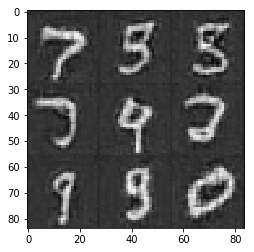

Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.1906
Epoch 2/2... Discriminator Loss: 0.4752... Generator Loss: 2.7570
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 0.7852
Epoch 2/2... Discriminator Loss: 0.4272... Generator Loss: 2.7830


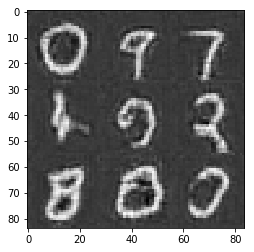

Epoch 2/2... Discriminator Loss: 0.3655... Generator Loss: 3.7477
Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 1.1013
Epoch 2/2... Discriminator Loss: 0.4716... Generator Loss: 2.1729
Epoch 2/2... Discriminator Loss: 0.4436... Generator Loss: 2.4623


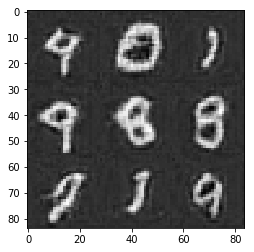

Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.6187
Epoch 2/2... Discriminator Loss: 0.4117... Generator Loss: 3.1050
Epoch 2/2... Discriminator Loss: 0.4720... Generator Loss: 3.2270
Epoch 2/2... Discriminator Loss: 1.7306... Generator Loss: 0.3885


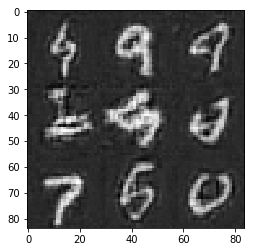

Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 1.2120
Epoch 2/2... Discriminator Loss: 0.6713... Generator Loss: 1.4177
Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 1.8102
Epoch 2/2... Discriminator Loss: 0.5023... Generator Loss: 2.3795


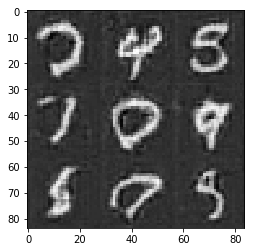

Epoch 2/2... Discriminator Loss: 0.3778... Generator Loss: 3.8245
Epoch 2/2... Discriminator Loss: 0.5653... Generator Loss: 1.6592
Epoch 2/2... Discriminator Loss: 0.4076... Generator Loss: 2.8167
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 0.6754


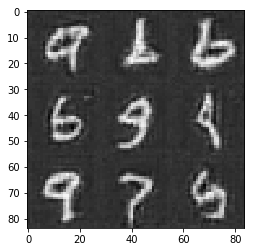

Epoch 2/2... Discriminator Loss: 0.3582... Generator Loss: 3.9184
Epoch 2/2... Discriminator Loss: 0.5831... Generator Loss: 1.6997
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 1.5562
Epoch 2/2... Discriminator Loss: 0.4696... Generator Loss: 2.2323


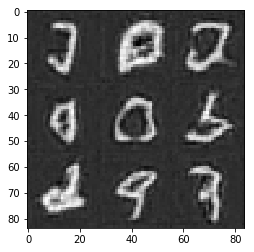

Epoch 2/2... Discriminator Loss: 0.4184... Generator Loss: 2.8494
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 3.2205
Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.2575
Epoch 2/2... Discriminator Loss: 0.3528... Generator Loss: 4.5271


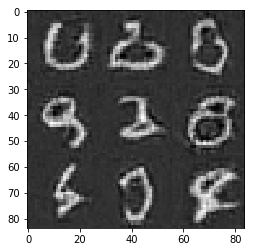

Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 2.2184
Epoch 2/2... Discriminator Loss: 0.4148... Generator Loss: 5.7396
Epoch 2/2... Discriminator Loss: 0.3795... Generator Loss: 3.4955
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 0.9293


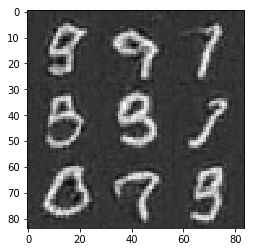

Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 1.1970
Epoch 2/2... Discriminator Loss: 0.7465... Generator Loss: 1.6698
Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 0.6631... Generator Loss: 1.4099


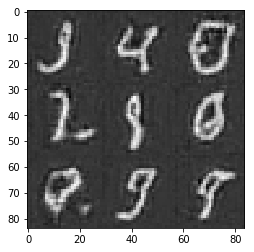

Epoch 2/2... Discriminator Loss: 1.1672... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 0.3535... Generator Loss: 4.1974
Epoch 2/2... Discriminator Loss: 0.4097... Generator Loss: 3.0550
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 0.8905


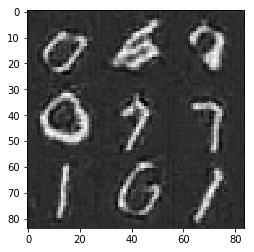

Epoch 2/2... Discriminator Loss: 0.5590... Generator Loss: 1.7856
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 1.0492
Epoch 2/2... Discriminator Loss: 0.7670... Generator Loss: 1.1551
Epoch 2/2... Discriminator Loss: 0.6579... Generator Loss: 1.6510


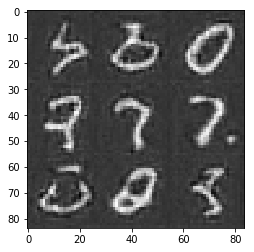

Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.3529
Epoch 2/2... Discriminator Loss: 2.2972... Generator Loss: 0.2233
Epoch 2/2... Discriminator Loss: 0.4144... Generator Loss: 3.4008
Epoch 2/2... Discriminator Loss: 0.4567... Generator Loss: 2.3677


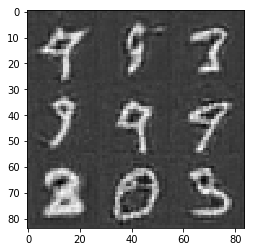

Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 1.1374
Epoch 2/2... Discriminator Loss: 0.3582... Generator Loss: 5.1988
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.5206


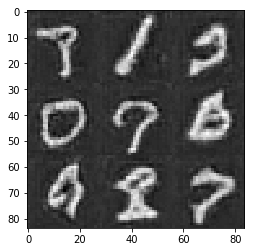

Epoch 2/2... Discriminator Loss: 0.8665... Generator Loss: 1.1985
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 1.7217
Epoch 2/2... Discriminator Loss: 0.6858... Generator Loss: 1.4387
Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 0.9493


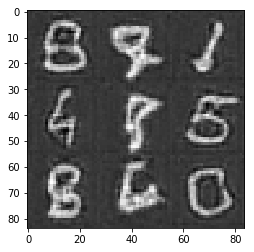

Epoch 2/2... Discriminator Loss: 0.7964... Generator Loss: 1.2338
Epoch 2/2... Discriminator Loss: 0.5977... Generator Loss: 1.9822
Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.2022


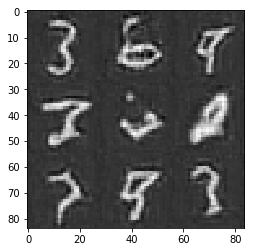

Epoch 2/2... Discriminator Loss: 0.7553... Generator Loss: 1.7395
Epoch 2/2... Discriminator Loss: 0.6260... Generator Loss: 2.0293
Epoch 2/2... Discriminator Loss: 0.5952... Generator Loss: 1.6525
Epoch 2/2... Discriminator Loss: 0.6164... Generator Loss: 1.6046


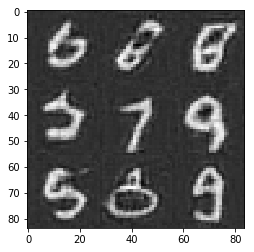

Epoch 2/2... Discriminator Loss: 1.3912... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.1501... Generator Loss: 0.7758
Epoch 2/2... Discriminator Loss: 0.6029... Generator Loss: 1.8466
Epoch 2/2... Discriminator Loss: 0.6133... Generator Loss: 1.6881


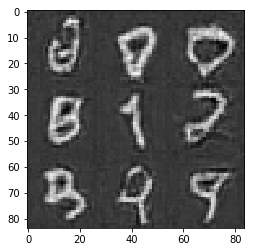

Epoch 2/2... Discriminator Loss: 1.1694... Generator Loss: 0.6665
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 2.3562
Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 0.7115... Generator Loss: 1.4356


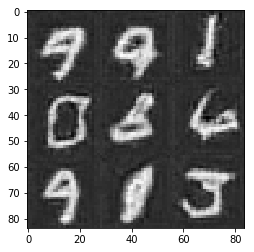

Epoch 2/2... Discriminator Loss: 0.4710... Generator Loss: 2.2764
Epoch 2/2... Discriminator Loss: 1.1255... Generator Loss: 0.6970
Epoch 2/2... Discriminator Loss: 1.8382... Generator Loss: 0.4863
Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 1.6611


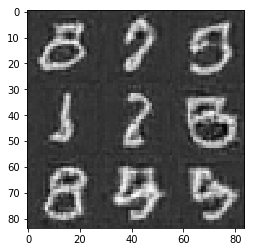

Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 0.4314... Generator Loss: 2.5323
Epoch 2/2... Discriminator Loss: 0.4535... Generator Loss: 2.4028
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 0.9813


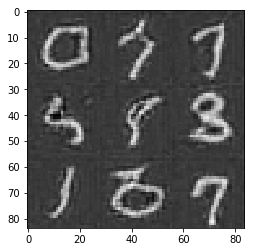

Epoch 2/2... Discriminator Loss: 1.2941... Generator Loss: 0.5774
Epoch 2/2... Discriminator Loss: 0.5270... Generator Loss: 2.0040
Epoch 2/2... Discriminator Loss: 0.3705... Generator Loss: 3.5331
Epoch 2/2... Discriminator Loss: 0.4203... Generator Loss: 2.7150


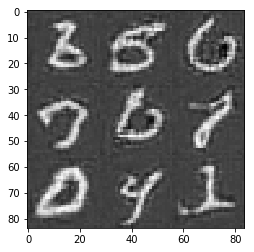

Epoch 2/2... Discriminator Loss: 0.5935... Generator Loss: 1.6279
Epoch 2/2... Discriminator Loss: 0.3499... Generator Loss: 5.2829
Epoch 2/2... Discriminator Loss: 1.0084... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 0.5107... Generator Loss: 2.0168


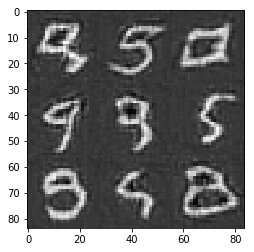

Epoch 2/2... Discriminator Loss: 0.3734... Generator Loss: 3.4701
Epoch 2/2... Discriminator Loss: 0.3423... Generator Loss: 5.7681
Epoch 2/2... Discriminator Loss: 0.4049... Generator Loss: 2.9066
Epoch 2/2... Discriminator Loss: 0.6575... Generator Loss: 1.4601


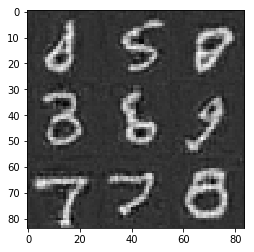

Epoch 2/2... Discriminator Loss: 0.3465... Generator Loss: 4.5271
Epoch 2/2... Discriminator Loss: 0.3543... Generator Loss: 3.9977
Epoch 2/2... Discriminator Loss: 0.3594... Generator Loss: 3.7437
Epoch 2/2... Discriminator Loss: 0.3378... Generator Loss: 6.8252


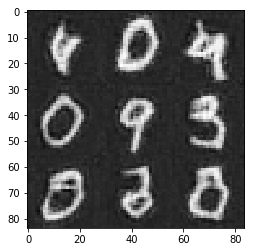

Epoch 2/2... Discriminator Loss: 0.6401... Generator Loss: 1.4996
Epoch 2/2... Discriminator Loss: 0.3689... Generator Loss: 3.4675
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 0.3456... Generator Loss: 6.0169


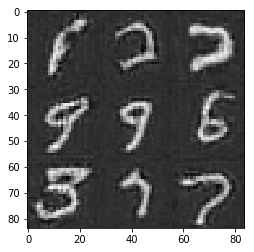

Epoch 2/2... Discriminator Loss: 1.8679... Generator Loss: 0.2860
Epoch 2/2... Discriminator Loss: 0.4670... Generator Loss: 4.0530
Epoch 2/2... Discriminator Loss: 0.5919... Generator Loss: 1.6540
Epoch 2/2... Discriminator Loss: 0.5382... Generator Loss: 1.8339


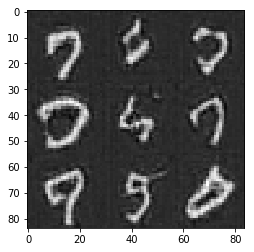

Epoch 2/2... Discriminator Loss: 0.4720... Generator Loss: 2.3118
Epoch 2/2... Discriminator Loss: 0.5718... Generator Loss: 1.7091
Epoch 2/2... Discriminator Loss: 0.5269... Generator Loss: 1.9088
Epoch 2/2... Discriminator Loss: 0.4237... Generator Loss: 3.0306


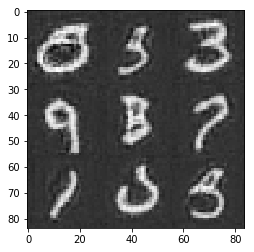

Epoch 2/2... Discriminator Loss: 0.3571... Generator Loss: 5.0646
Epoch 2/2... Discriminator Loss: 0.3392... Generator Loss: 8.1405
Epoch 2/2... Discriminator Loss: 1.4649... Generator Loss: 0.5741
Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 1.0756


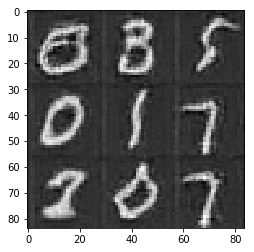

Epoch 2/2... Discriminator Loss: 0.6749... Generator Loss: 1.7381
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 1.2804
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.1431
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.7588


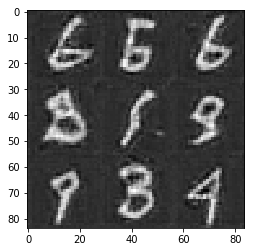

Epoch 2/2... Discriminator Loss: 0.7642... Generator Loss: 1.2175
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 1.0155
Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 1.7048
Epoch 2/2... Discriminator Loss: 0.8777... Generator Loss: 1.1036


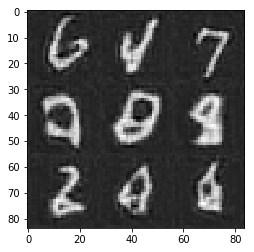

Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 0.8489
Epoch 2/2... Discriminator Loss: 0.5395... Generator Loss: 1.9700
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 1.9236
Epoch 2/2... Discriminator Loss: 0.3377... Generator Loss: 5.6417


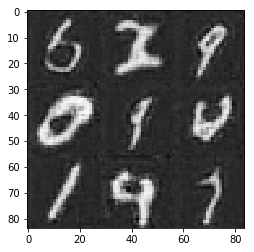

Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.0437
Epoch 2/2... Discriminator Loss: 0.4030... Generator Loss: 4.2981
Epoch 2/2... Discriminator Loss: 0.3544... Generator Loss: 4.9879


In [27]:
batch_size = 16
z_dim = 50
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = 100
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.